## Hotels Challenge II.

given a database of hotels, and a set of input coordinates, price ranges and star ratings, for each coordinate-pricerange-startrating combination, find the hotel closest to the coordinates with the given start rating and within the price range. if no hotel fits in the price range star rating combination, return the dict `{"missing": True}`

a solution is represented the same way as in [challenge one](../../challenge-1-hotels/draft_notebooks/challenge-draft-v0.ipynb), input sizes are the same as well, outputs now must include star-rating and price as well

### install package for data downloading and evaluation

In [ ]:
#!pip install --upgrade git+https://github.com/endreMBorza/jkg_evaluators

In [1]:
from jkg_evaluators.challenges.data.hotels import get_hotel_data, dump_hotel_filter_input # dump_hotel_filter_input nekem ezt nem tudja importálni
import shutil
import os

### download practice data

In [6]:
#get_hotel_data()

### select one and move to notebook root

In [2]:
data_size_to_copy = 10000
shutil.copyfile(os.path.join("data", 
                             f"{data_size_to_copy}.csv"), 
                "data.csv")

'data.csv'

### generate some inputs

In [3]:
dump_hotel_filter_input(size=10, path="inputs.json")

## base solution ETL

In [4]:
%%time
import pandas as pd

data_file_path = "data.csv"

df = pd.read_csv(data_file_path)

df.drop_duplicates().assign(
    price=lambda _df: _df["current-price"]
    .str[1:]
    .str.replace(",", "")
    .astype(float)
).loc[:, ["lon", "lat", "name", "stars", "price"]].to_pickle("filtered.pkl")


Wall time: 92 ms


### ETL with stardicts

In [5]:
%%time
import pandas as pd

data_file_path = "data.csv"

df = pd.read_csv(data_file_path)

df = df.drop_duplicates().assign(
    price=lambda _df: _df["current-price"]
    .str[1:]
    .str.replace(",", "")
    .astype(float)
).loc[:, ["lon", "lat", "name", "stars", "price"]]

starunique = sorted(df['stars'].unique())
stardict = {elem : pd.DataFrame() for elem in starunique}

for key in stardict.keys():
    stardict[key] = df[df['stars'] == key]
    stardict[key].to_pickle("star{}.pkl".format(key))

pd.DataFrame(columns = ['lon', 'lat', 'name', 'stars', 'price']).to_pickle("star0.0.pkl")
pd.DataFrame(columns = ['lon', 'lat', 'name', 'stars', 'price']).to_pickle("star0.5.pkl")

Wall time: 235 ms


Index(['lon', 'lat', 'name', 'stars', 'price'], dtype='object')

## base solution process

In [80]:
%%time
import pandas as pd
import numpy as np
import json

input_dicts = json.load(open("inputs.json", "r"))

df = pd.read_pickle("filtered.pkl")

min_distances = [np.inf] * len(input_dicts)

answers = [{"missing": True}] * len(input_dicts)
for idx, row in df.iterrows():

    for input_idx, input_dict in enumerate(input_dicts):
        if row["stars"] != input_dict["stars"]:
            continue
        if (row["price"] > input_dict["max_price"]) or (
            row["price"] < input_dict["min_price"]
        ):
            continue
        distance = (
            (input_dict["lon"] - row["lon"]) ** 2
            + (input_dict["lat"] - row["lat"]) ** 2
        ) ** 0.5
        if distance < min_distances[input_idx]:
            min_distances[input_idx] = distance
            answers[input_idx] = row[["lon", "lat", "name", "stars", "price"]].to_dict()

json.dump(answers, open("outputs.json", "w"))


KeyboardInterrupt: 

In [81]:
answers

[{'lon': -63.88299,
  'lat': -8.76936,
  'name': 'Hotel Porto Madeira',
  'stars': 3.0,
  'price': 38.0},
 {'lon': -98.382013,
  'lat': 29.437828000000003,
  'name': 'OYO Hotel San Antonio East',
  'stars': 1.5,
  'price': 58.0},
 {'lon': 49.824262,
  'lat': 40.305247,
  'name': 'Sapphire Marine',
  'stars': 4.5,
  'price': 61.0},
 {'missing': True},
 {'lon': 48.493405,
  'lat': 28.490081,
  'name': 'Raoum Inn Khafji Corniche',
  'stars': 3.5,
  'price': 106.0},
 {'lon': 1.6683599999999998,
  'lat': 42.431239,
  'name': 'Refugi Cap del Rec',
  'stars': 1.5,
  'price': 65.0},
 {'lon': 18.03486,
  'lat': 46.90418,
  'name': 'Princess Apartman',
  'stars': 3.5,
  'price': 29.0},
 {'lon': 79.90681,
  'lat': 7.178856,
  'name': 'OYO 309 Green View Hotel',
  'stars': 2.0,
  'price': 28.0},
 {'lon': 79.841895,
  'lat': 7.2362,
  'name': "Bernie's inn",
  'stars': 1.5,
  'price': 20.0},
 {'missing': True},
 {'lon': 105.778023,
  'lat': 10.034754,
  'name': 'Karan Homestay - Hostel',
  'stars':

## Little better solution process  (ETL = with start dicts)

In [7]:
%%time
# alter 1 - little better
import json
from sklearn.neighbors import KDTree
input_dicts = json.load(open("inputs.json", "r"))

min_distances = [np.inf] * len(input_dicts)

answers = [{"missing": True}] * len(input_dicts)
#input_dicts[:] = [d for d in input_dicts if (d.get('stars') != 0.0 ) if (d.get('stars') != 0.5)]

for input_idx, input_dict in enumerate(input_dicts):
    try:
        df = pd.read_pickle("star{}.pkl".format(input_dict['stars']))
    except:
        continue
    for idx, row in df.iterrows():
        if (row["price"] < input_dict["max_price"]) and (row["price"] > input_dict["min_price"]):
            distance = ((input_dict["lon"] - row["lon"]) ** 2 + (input_dict["lat"] - row["lat"]) ** 2)
            if distance < min_distances[input_idx]:
                min_distances[input_idx] = distance
                answers[input_idx] = row[["lon", "lat", "name", "stars", "price"]].to_dict()



Wall time: 10.8 s


In [17]:
input_dicts

({'lat': 16.955629217959665,
  'lon': 5.635504184743301,
  'stars': 0.0,
  'min_price': 10.966974856796528,
  'max_price': 107.17903617378138},
 {'lat': 41.44198128295216,
  'lon': 98.34514573326429,
  'stars': 2.5,
  'min_price': 5.741689982682395,
  'max_price': 11.772494031495878},
 {'lat': -39.931555762557124,
  'lon': 32.42759335779557,
  'stars': 4.5,
  'min_price': 34.247587675731076,
  'max_price': 56.9480153557023},
 {'lat': -1.251917000719971,
  'lon': -105.62754246490186,
  'stars': 4.0,
  'min_price': 15.472820713662449,
  'max_price': 42.47782738716001},
 {'lat': -28.17357048329027,
  'lon': 32.51354567302423,
  'stars': 0.0,
  'min_price': 75.20203146674753,
  'max_price': 162.55570561458268},
 {'lat': 21.86167786248655,
  'lon': -47.205029589725584,
  'stars': 4.5,
  'min_price': 12.442714465853737,
  'max_price': 124.86982772553394},
 {'lat': -32.544457716074525,
  'lon': -44.63941033744268,
  'stars': 5.0,
  'min_price': 81.78514016132557,
  'max_price': 106.3761004279

In [52]:
#answers

## Realtively fast with KDtree (ETL = base ETL)

In [14]:
%%time
## sklearn KDtree_old
import json
from sklearn.neighbors import KDTree
input_dicts = json.load(open("inputs.json", "r"))
df = pd.read_pickle("filtered.pkl")
answers = []


def filter(data, input_):
    
    data = data[data['stars'] == input_['stars']]
    data = data[data['price'] >= input_['min_price']]
    data = data[data['price'] <= input_['max_price']]
    
    if len(data) > 0:
        return data, data
    else:
        return data, answers.append({"missing": True})
    
for input_idx, input_dict in enumerate(input_dicts):
    data = filter(df, input_dict)
    data = data[0]
    if len(data) > 0:
        query_all = (input_dict['lat'], input_dict['lon'])
        query_all = np.array(query_all)
        query_all = query_all.reshape(1,-1)
        tree = KDTree(data[['lat', 'lon']].values)
        dist, ind = tree.query(query_all)
        [answers.append(dict(data.iloc[i[0]])) for i in ind]

json.dump(answers,open('outputs.json','w'))
    

Wall time: 341 ms


In [113]:
%%time
## sklearn KDtree_old with star preload - slower than original KDtree
import json
from sklearn.neighbors import KDTree
input_dicts = json.load(open("inputs.json", "r"))
answers2 = []
min_distances = [np.inf] * len(input_dicts)

def filter(data, input_):
    data = data[data['price'] >= input_['min_price']]
    data = data[data['price'] <= input_['max_price']]    
    return data
    
for input_idx, input_dict in enumerate(input_dicts):
    try:
        data = filter(pd.read_pickle("star{}.pkl".format(input_dict['stars'])), input_dict)
        if len(data) > 0:
            query_all = (input_dict['lat'], input_dict['lon'])
            query_all = np.array(query_all)
            query_all = query_all.reshape(1,-1)
            tree = KDTree(data[['lat', 'lon']].values)
            dist, ind = tree.query(query_all)
            [answers2.append(dict(data.iloc[i[0]])) for i in ind]
        else:
            answers2.append({"missing": True})
    except:
        answers2.append({"missing": True})
        continue
    


json.dump(answers,open('outputs.json','w'))

Wall time: 6.05 s


In [7]:
%%time
## sklearn KDtree - faster
import json
from sklearn.neighbors import KDTree
import pandas as pd
import numpy as np

input_dicts = tuple(json.load(open("inputs.json", "r")))
df = pd.read_pickle("filtered.pkl")
answers = []


def filter(data, input_):
    
    for input_idx, input_dict in enumerate(input_):
        data = data[data['stars'] == input_dict['stars']]
        data = data[data['price'] >= input_dict['min_price']]
        data = data[data['price'] <= input_dict['max_price']]
    
        if len(data) > 0:
            query_all = (input_dict['lat'], input_dict['lon'])
            query_all = np.array(query_all)
            query_all = query_all.reshape(1,-1)
            tree = KDTree(data[['lat', 'lon']].values)
            dist, ind = tree.query(query_all)
            [answers.append(dict(data.iloc[i[0]])) for i in ind]


        else:
            answers.append({"missing": True})
        data = df
    return answers
    
answers2 = filter(df, input_dicts)

json.dump(answers2,open('outputs.json','w'))

Wall time: 4.69 s


-------
**Ezek a verziók a versenyképesek**
- pykdtree KDtree - fastest: Ez a leggyorsabb
- pykdtree KDtree w/o append: Ebben az append helyett az Endre féle megoldást használtam, kb ugyan olyan gyors mint az előző
- pykdtree KDtree with star preload: Ez az első verzió olyan változata amikor betöltjük a starokat (ehhez a másik ETL kell), ez most lassabb, de ha jól értem a flask-nak itt lehet potenciálja

In [7]:
%%time
## pykdtree KDtree - fastest
import json
from pykdtree.kdtree import KDTree
import pandas as pd
import numpy as np

input_dicts = tuple(json.load(open("inputs.json", "r")))
df = pd.read_pickle("filtered.pkl")


def filter(data, input_):
    answers = []
    for input_idx, input_dict in enumerate(input_):
        data = data[data['stars'] == input_dict['stars']]
        data = data[data['price'] >= input_dict['min_price']]
        data = data[data['price'] <= input_dict['max_price']]
    
        if len(data) > 0:
            query_all = (input_dict['lat'], input_dict['lon'])
            query_all = np.array(query_all)
            query_all = query_all.reshape(1,-1)
            tree = KDTree(data[['lat', 'lon']].values)
            dist, ind = tree.query(query_all)
            [answers.append(dict(data.iloc[i])) for i in ind]


        else:
            answers.append({"missing": True})
        data = df
    return answers


answers2 = filter(df, input_dicts)

json.dump(answers2,open('outputs.json','w'))

Wall time: 51 ms


In [8]:
answers2

[{'lon': 7.4759410000000015,
  'lat': 9.072601,
  'name': 'Emzrel Hotel & Suites',
  'stars': 3.0,
  'price': 114.0},
 {'lon': 100.580396,
  'lat': 13.730539000000002,
  'name': 'Thonglo 7 Hostels',
  'stars': 2.0,
  'price': 73.0},
 {'lon': 32.418676,
  'lat': -28.374339000000006,
  'name': 'Fishermans Flat',
  'stars': 2.5,
  'price': 47.0},
 {'lon': -88.203734,
  'lat': 20.703416,
  'name': 'Hotel Avila',
  'stars': 2.0,
  'price': 40.0},
 {'missing': True},
 {'lon': -66.109187,
  'lat': 43.866081,
  'name': 'El Rancho Motel',
  'stars': 2.0,
  'price': 70.0},
 {'lon': -48.48428,
  'lat': -27.43858,
  'name': 'Casa RECREANEXT',
  'stars': 2.0,
  'price': 49.0},
 {'lon': 44.512674,
  'lat': 40.176234,
  'name': 'Hyatt Place Yerevan',
  'stars': 4.0,
  'price': 84.0},
 {'missing': True},
 {'lon': -13.868182,
  'lat': 28.730509,
  'name': 'Alisios Playa',
  'stars': 2.5,
  'price': 80.0}]

In [152]:
%%time
## pykdtree KDtree w/o append - same as with append (Néha az egyik gyorsabb néha a másik)
import json
from pykdtree.kdtree import KDTree
import pandas as pd
import numpy as np

input_dicts = tuple(json.load(open("inputs.json", "r")))
df = pd.read_pickle("filtered.pkl")


def filter(data, input_):
    answers = [None]*len(input_dicts)
    for input_idx, input_dict in enumerate(input_):
        data = data[data['stars'] == input_dict['stars']]
        data = data[data['price'] >= input_dict['min_price']]
        data = data[data['price'] <= input_dict['max_price']]
    
        if len(data) > 0:
            query_all = (input_dict['lat'], input_dict['lon'])
            query_all = np.array(query_all)
            query_all = query_all.reshape(1,-1)
            tree = KDTree(data[['lat', 'lon']].values)
            dist, ind = tree.query(query_all)
            answers[input_idx] = data.iloc[ind].to_dict('records')[0]


        else:
            answers[input_idx] = {"missing": True}
        data = df
    return answers


answers2 = filter(df, input_dicts)

json.dump(answers2,open('outputs.json','w'))

Wall time: 4.14 s


In [150]:
## pykdtree KDtree with star preload - slower than w/o
import json
from pykdtree.kdtree import KDTree
import pandas as pd
import numpy as np

input_dicts = tuple(json.load(open("inputs.json", "r")))
answers = []


def filter(input_):
    
    for input_idx, input_dict in enumerate(input_):
        data = pd.read_pickle("star{}.pkl".format(input_dict['stars']))
        data = data[data['price'] >= input_dict['min_price']]
        data = data[data['price'] <= input_dict['max_price']]

    
        if len(data) > 0:
            
            query_all = (input_dict['lat'], input_dict['lon'])
            query_all = np.array(query_all)
            query_all = query_all.reshape(1,-1)
            tree = KDTree(data[['lat', 'lon']].values)
            dist, ind = tree.query(query_all)
            [answers.append(dict(data.iloc[i])) for i in ind]

        else:
            answers.append({"missing": True})
    return answers

answers2 = filter(input_dicts)

json.dump(answers2,open('outputs.json','w'))

In [ ]:
%%time
## pykdtree KDtree - fastest
import json
from pykdtree.kdtree import KDTree
import pandas as pd
import numpy as np

input_dicts = tuple(json.load(open("inputs.json", "r")))
df = pd.read_pickle("filtered.pkl")


def filter(data, input_):
    answers = []
    for input_idx, input_dict in enumerate(input_):
        data = data[data['stars'] == input_dict['stars']]
        data = data[data['price'] >= input_dict['min_price']]
        data = data[data['price'] <= input_dict['max_price']]
    
        if len(data) > 0:
            query_all = (input_dict['lat'], input_dict['lon'])
            query_all = np.array(query_all)
            query_all = query_all.reshape(1,-1)
            tree = KDTree(data[['lat', 'lon']].values)
            dist, ind = tree.query(query_all)
            [answers.append(dict(data.iloc[i])) for i in ind]


        else:
            answers.append({"missing": True})
        data = df
    return answers


answers2 = filter(df, input_dicts)

json.dump(answers2,open('outputs.json','w'))

### For flask -with sklearn kdtree

In [9]:
%%time
#w/o star preload
import json
from sklearn.neighbors import KDTree
import pandas as pd
import numpy as np

input_dicts = tuple(json.load(open("inputs.json", "r")))
df = pd.read_pickle("filtered.pkl")


def filter(data, input_):
    answers = []
    for input_idx, input_dict in enumerate(input_):
        data = data[data['stars'] == input_dict['stars']]
        data = data[data['price'] >= input_dict['min_price']]
        data = data[data['price'] <= input_dict['max_price']]
    
        if len(data) > 0:
            query_all = (input_dict['lat'], input_dict['lon'])
            query_all = np.array(query_all)
            query_all = query_all.reshape(1,-1)
            tree = KDTree(data[['lat', 'lon']].values)
            dist, ind = tree.query(query_all)
            [answers.append(dict(data.iloc[i[0]])) for i in ind]


        else:
            answers.append({"missing": True})
        data = df
    return answers


answers2 = filter(df, input_dicts)

json.dump(answers2,open('outputs.json','w'))

Wall time: 59 ms


In [11]:
#answers2

In [12]:
import json
from sklearn.neighbors import KDTree
import pandas as pd
import numpy as np

input_dicts = tuple(json.load(open("inputs.json", "r")))
answers = []


def filter(input_):
    
    for input_idx, input_dict in enumerate(input_):
        data = pd.read_pickle("star{}.pkl".format(input_dict['stars']))
        data = data[data['price'] >= input_dict['min_price']]
        data = data[data['price'] <= input_dict['max_price']]

    
        if len(data) > 0:
            
            query_all = (input_dict['lat'], input_dict['lon'])
            query_all = np.array(query_all)
            query_all = query_all.reshape(1,-1)
            tree = KDTree(data[['lat', 'lon']].values)
            dist, ind = tree.query(query_all)
            [answers.append(dict(data.iloc[i[0]])) for i in ind]

        else:
            answers.append({"missing": True})
    return answers

answers2 = filter(input_dicts)

json.dump(answers2,open('outputs.json','w'))

-------

2020.03.21. - itt csak kísérletezem, ez már nem fontos

In [154]:
%lprun -f filter() filter(input_dicts)

UsageError: Line magic function `%lprun` not found.


In [185]:
%%time
## pykdtree KDtree - fastest
import json
from pykdtree.kdtree import KDTree
import pandas as pd
import numpy as np

df = pd.read_pickle("filtered.pkl")
def filter(data):
    input_ = tuple(json.load(open("inputs.json", "r")))
    answers = []
    for input_idx, input_dict in enumerate(input_):
        data = data[data['stars'] == input_dict['stars']]
        data = data[data['price'] >= input_dict['min_price']]
        data = data[data['price'] <= input_dict['max_price']]
    
        if len(data) > 0:
            query_all = (input_dict['lat'], input_dict['lon'])
            query_all = np.array(query_all)
            query_all = query_all.reshape(1,-1)
            tree = KDTree(data[['lat', 'lon']].values)
            dist, ind = tree.query(query_all)
            [answers.append(dict(data.iloc[i])) for i in ind]


        else:
            answers.append({"missing": True})
        data = df
    
    json.dump(answers2,open('outputs.json','w'))



answers2 = filter(df)



Wall time: 3.41 s


In [240]:
dump_hotel_filter_input(size = 1000, path="inputs.json")

In [300]:
lst = []
for i in range(1000):
    dump_hotel_filter_input(size = 1000, path="inputs.json")
    input_ = json.load(open("inputs.json", "r"))
    a = pd.DataFrame(input_)
    lst.append(a['max_price'].max())

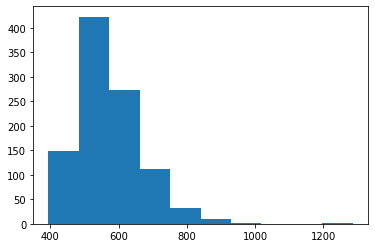

In [301]:
import matplotlib.pyplot as plt
plt.hist(lst);

In [305]:
sorted(lst)

[394.2807883505637,
 398.3880412379162,
 401.27485631128667,
 410.62315356373443,
 411.2298956311864,
 414.44296576869806,
 415.9024089688551,
 416.8899559928422,
 416.93647549450196,
 417.78428216453005,
 417.9349659225445,
 420.30615550435357,
 423.90240560602035,
 423.96904681199015,
 425.82735661751025,
 426.5180766325013,
 427.9617329028407,
 428.5004206695639,
 429.83791441746956,
 430.7200498354422,
 431.3505912595644,
 433.082820641484,
 433.8874709596794,
 436.7948467723498,
 438.1578477912824,
 438.33094084081466,
 438.9509044315505,
 439.48629968354714,
 440.20665114517254,
 441.20057896829985,
 441.8686444998252,
 442.78976409103893,
 442.97703689750705,
 445.09059290378866,
 445.2792064928093,
 445.33983539590236,
 446.03954242729645,
 447.7347055325392,
 448.4457439473244,
 448.45412491509893,
 449.1664225522774,
 449.91814448831974,
 450.3045521799762,
 450.4002935231007,
 451.3053815066115,
 451.4578104978233,
 451.48365228831346,
 451.67035522021575,
 451.7506027390619

In [245]:
input_ = json.load(open("inputs.json", "r"))

[458.99462554800755, 458.99462554800755, 458.99462554800755, 458.99462554800755, 458.99462554800755, 458.99462554800755, 458.99462554800755, 458.99462554800755, 458.99462554800755, 458.99462554800755, 458.99462554800755, 458.99462554800755, 458.99462554800755, 458.99462554800755, 458.99462554800755, 458.99462554800755, 458.99462554800755, 458.99462554800755, 458.99462554800755, 458.99462554800755, 458.99462554800755, 458.99462554800755, 458.99462554800755, 458.99462554800755, 458.99462554800755, 458.99462554800755, 458.99462554800755, 458.99462554800755, 458.99462554800755, 458.99462554800755, 458.99462554800755, 458.99462554800755, 458.99462554800755, 458.99462554800755, 458.99462554800755, 458.99462554800755, 458.99462554800755, 458.99462554800755, 458.99462554800755, 458.99462554800755, 458.99462554800755, 458.99462554800755, 458.99462554800755, 458.99462554800755, 458.99462554800755, 458.99462554800755, 458.99462554800755, 458.99462554800755, 458.99462554800755, 458.99462554800755,

In [241]:
a = pd.DataFrame(input_)


458.99462554800755

In [264]:
%%time
import pandas as pd

data_file_path = "data.csv"

df = pd.read_csv(data_file_path)

df = df.drop_duplicates().assign(
    price=lambda _df: _df["current-price"]
    .str[1:]
    .str.replace(",", "")
    .astype(float)
).loc[:, ["lon", "lat", "name", "stars", "price"]]

df[df['price'] < 1500].to_pickle("filtered.pkl")


Wall time: 110 ms


In [281]:
import json
from pykdtree.kdtree import KDTree
import pandas as pd
import numpy as np

input_dicts = tuple(json.load(open("inputs.json", "r")))
answers = []

df = pd.read_pickle("filtered.pkl")

def filter(data, input_):
    
    for input_idx, input_dict in enumerate(input_):
        data = data[data['stars'] == input_dict['stars']]
    
        if len(data) > 0:
            
            query_all = (input_dict['lat'], input_dict['lon'])
            query_all = np.array(query_all)
            query_all = query_all.reshape(1,-1)
            tree = KDTree(data[['lat', 'lon']].values)
            dist, ind = tree.query(query_all)
            [answers.append(dict(data.iloc[i])) for i in ind]

        else:
            answers.append({"missing": True})
        data = df
    return answers

answers2 = filter(df,input_dicts)

json.dump(answers2,open('outputs.json','w'))

In [283]:
answers2

[{'lon': -64.681483,
  'lat': 17.75416,
  'name': 'The Buccaneer',
  'stars': 4.5,
  'price': 540.0},
 {'lon': 80.431878,
  'lat': 5.972471,
  'name': 'Golden Bay Resort',
  'stars': 2.5,
  'price': 19.0},
 {'lon': -15.97554,
  'lat': 18.09501,
  'name': 'Al Khaima City Center',
  'stars': 4.0,
  'price': 130.0},
 {'lon': -54.44700400000001,
  'lat': -25.679774,
  'name': 'Gran Melia Iguazú',
  'stars': 5.0,
  'price': 297.0},
 {'missing': True},
 {'lon': -6.8293610000000005,
  'lat': 33.982389000000005,
  'name': 'Villa Des Ambassadors',
  'stars': 4.5,
  'price': 130.0},
 {'lon': -9.193041,
  'lat': 42.956587,
  'name': 'Hotel Oca Insua',
  'stars': 3.0,
  'price': 48.0},
 {'missing': True},
 {'lon': -13.862425,
  'lat': 28.725539,
  'name': 'Arena Beach',
  'stars': 3.5,
  'price': 131.0},
 {'lon': -75.5597,
  'lat': 10.40005,
  'name': 'Intercontinental Cartagena De Indias',
  'stars': 4.5,
  'price': 138.0}]